In [1]:
%env CUDA_VISIBLE_DEVICES=0,1,2,3

env: CUDA_VISIBLE_DEVICES=0,1,2,3


In [2]:
fig_scale = 1.#2./3.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as onp
import h5py

import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from scipy.stats import norm

from time import time
import json

import os, sys
sys.path.append(os.path.split(os.getcwd())[0])
import scripts.transform_data as transform

In [4]:
plt.rcParams['font.size'] = 14

In [5]:
N_GPU = sum([i.isdigit() for i in os.environ.get('CUDA_VISIBLE_DEVICES')])
if N_GPU>0:
    numpyro.set_platform('gpu')   
    numpyro.set_host_device_count(N_GPU)
    N_chains = N_GPU
else:
    N_chains = 1

print(jax.devices())    

[GpuDevice(id=0), GpuDevice(id=1), GpuDevice(id=2), GpuDevice(id=3)]


# Process Data

In [6]:
c_df, r_df, d_df = transform.IRD(min_confirmed=0, min_recovered=0, min_deaths=20)

[265, 252, 91]


In [7]:
t_df, h_df, w_df = transform.weather(update=False)

In [8]:
deaths = {}
temps = {}
hums = {}
start_days = np.argmax((d_df.values>3),axis=1)
end_days = np.argmax((d_df.values>1000), axis=1)
for i, country in enumerate(d_df.index):
    climate_delay = 28    # days between infection and death
    if start_days[i]<climate_delay:
        climate_delay = start_days[i]
    if len(d_df.T[country].values[start_days[i]:])>10 and start_days[i]>0:
        if end_days[i]>0:
            time_slice = slice(start_days[i]-climate_delay, end_days[i]-climate_delay)
            deaths[country] = d_df.T[country].values[start_days[i]:end_days[i]]
            temps[country] = np.nanmean(t_df.T[country].values[time_slice])
            hums[country] = np.nanmean(h_df.T[country].values[time_slice])
        else:
            deaths[country] = d_df.T[country].values[start_days[i]:]
            temps[country] = np.nanmean(t_df.T[country].values[start_days[i]-climate_delay:])
            hums[country] = np.nanmean(h_df.T[country].values[start_days[i]-climate_delay:])

In [9]:
temps.keys()

dict_keys(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Argentina', 'Armenia', 'Australia / New South Wales', 'Austria', 'Azerbaijan', 'Bangladesh', 'Belarus', 'Belgium', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Cameroon', 'Canada / Alberta', 'Canada / British Columbia', 'Canada / Ontario', 'Canada / Quebec', 'Chile', 'China / Henan', 'Colombia', 'Congo (Kinshasa)', 'Croatia', 'Cuba', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Honduras', 'Hungary', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan', 'Kazakhstan', 'Korea, South', 'Lebanon', 'Lithuania', 'Luxembourg', 'Malaysia', 'Mexico', 'Moldova', 'Morocco', 'Netherlands', 'Niger', 'Nigeria', 'North Macedonia', 'Norway', 'Pakistan', 'Panama', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'San Marino', 'Saudi Arabia', 'Serbia', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Swit

In [10]:
samples = {}
with h5py.File('../data/nb_samples/4.1.0.1_STEP_EXP_Independent_samples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)][()]
countries = onp.loadtxt('../data/nb_samples/4.1.0.1_STEP_EXP_Independent_countries.txt', 
                        delimiter='|', dtype=str)[:,0]
t0 = np.mean(samples['t0'], axis=0)
t0_dict = dict(zip(countries, t0.astype(np.int32)))

In [11]:
all_countries = list(set(temps.keys()).intersection(countries[t0>10]))

In [12]:
len(all_countries)

66

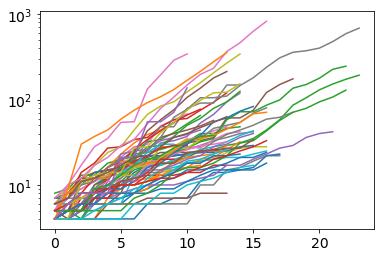

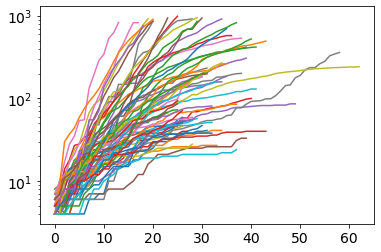

In [13]:
for c in countries[t0>10]:
    plt.semilogy(deaths[c][:t0_dict[c]])
plt.figure()
for c in countries[t0>10]:
    plt.semilogy(deaths[c])

In [14]:
countries[t0>10], len(countries[t0>10])

(array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Argentina',
        'Australia / New South Wales', 'Austria', 'Belarus', 'Bolivia',
        'Bosnia and Herzegovina', 'Bulgaria', 'Burkina Faso',
        'Canada / Alberta', 'Canada / British Columbia',
        'Canada / Ontario', 'Canada / Quebec', 'Chile', 'Colombia',
        'Congo (Kinshasa)', 'Croatia', 'Cuba', 'Czechia', 'Denmark',
        'Ecuador', 'Egypt', 'Estonia', 'Finland', 'France', 'Germany',
        'Greece', 'Honduras', 'Hungary', 'India', 'Iran', 'Iraq', 'Israel',
        'Italy', 'Japan', 'Korea, South', 'Lebanon', 'Lithuania',
        'Luxembourg', 'Mexico', 'Moldova', 'Morocco', 'Netherlands',
        'North Macedonia', 'Norway', 'Pakistan', 'Panama', 'Peru',
        'Philippines', 'Poland', 'San Marino', 'Slovenia', 'South Africa',
        'Spain', 'Sweden', 'Switzerland', 'Thailand', 'Tunisia', 'Turkey',
        'Ukraine', 'United Arab Emirates', 'United Kingdom', 'US'],
       dtype='<U27'), 66)

In [15]:
with h5py.File('../data/nb_samples/4.1.1.8.4_INCL_BLOOD_MultiVariate_Regression_samples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[key][()]

In [16]:
all_countries = [c.decode() for c in samples['countries']]

In [17]:
len(all_countries)

40

# Bayesian Model

In [18]:
def normalHP(name, mean, std, N_child):

    # Group mean
    grp_mean = numpyro.sample(str(name)+'_grp_mean', dist.Normal(mean, std))
    # Group variance
    grp_sigma = numpyro.sample(str(name)+'_grp_sigma', dist.HalfNormal(std))
    # Individual param
    ind = numpyro.sample(str(name)+'_ind', dist.Normal(grp_mean*np.ones(N_child), grp_sigma*np.ones(N_child)))
    
    return ind

In [19]:
def model():
    
    N = len(all_countries)
    
    Di = normalHP('Di', 7.0, 3.0, N)
    GR = normalHP('GR', 1.2, 0.5, N)
    alpha = numpyro.sample('alpha', dist.Normal(0.0, 0.01))

    # Create likelihood for each country    
    for i, country in enumerate(all_countries):
        dead = deaths[country][:t0_dict[country]]
        t = np.arange(len(dead))
        prediction = Di[i]*(GR[i]+alpha*temps[country])**t
        numpyro.sample(country, dist.Poisson(prediction), # Exponential regression
                       obs=dead)

In [20]:
N = len(all_countries)

scale = 0.5

init_params = {'Di_grp_mean': 7.0*np.ones((N_chains, 1)) + 3.0*scale*onp.random.randn(N_chains, 1),
               'GR_grp_mean': 1.2*np.ones((N_chains, 1)) + 0.5*scale*onp.random.randn(N_chains, 1),
               'Di_grp_sigma': 0.0*np.ones((N_chains, 1)) + 0.1*np.abs(scale*onp.random.randn(N_chains, 1)),
               'GR_grp_sigma': 0.0*np.ones((N_chains, 1)) + 0.1*np.abs(scale*onp.random.randn(N_chains, 1)),
               'Di_ind': 7.0*np.ones((N_chains, N)) + 3.0*scale*onp.random.randn(N_chains, N),
               'GR_ind': 1.2*np.ones((N_chains, N)) + 0.2*scale*onp.random.randn(N_chains, N),
               'alpha': 0.0*np.ones((N_chains, 1)) + 0.01*scale*onp.random.randn(N_chains, 1),
              }
if N_chains==1:
    for key in init_params.keys():
        init_params[key] = init_params[key][0]

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=2500, num_chains=N_chains)
rng_key = random.PRNGKey(0)

In [21]:
s = time()
mcmc.run(rng_key, extra_fields=('potential_energy',), init_params=init_params)
print(f'Time taken to compile model and draw samples : {time()-s} s')

Time taken to compile model and draw samples : 3879.7941012382507 s


In [22]:
samples = mcmc.get_samples()
with h5py.File('../data/nb_samples/4.1.1.2.5_WIDEPRIOR_0.5_TEMP_Regression_samples.h5', 'w') as fp:
    for key in samples.keys():
        fp[key] = samples[key]
    fp['potential_energy'] = mcmc.get_extra_fields()['potential_energy']
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
 Di_grp_mean[0]      5.63      0.38      5.63      5.00      6.24  17354.09      1.00
Di_grp_sigma[0]      2.21      0.30      2.19      1.72      2.67  12333.52      1.00
      Di_ind[0]      8.47      0.74      8.44      7.28      9.67  15787.00      1.00
      Di_ind[1]      4.86      0.58      4.84      3.90      5.77  17663.99      1.00
      Di_ind[2]      3.82      0.62      3.78      2.83      4.83  15071.14      1.00
      Di_ind[3]      6.90      0.51      6.88      6.09      7.76  19472.70      1.00
      Di_ind[4]      3.71      0.72      3.66      2.58      4.87  16496.87      1.00
      Di_ind[5]      6.92      0.88      6.89      5.50      8.37  19357.50      1.00
      Di_ind[6]      3.32      0.64      3.28      2.27      4.34  16170.02      1.00
      Di_ind[7]      5.05      0.74      5.01      3.78      6.21  16999.13      1.00
      Di_ind[8]      4.64      0.91      4.60      3.

In [6]:
samples = {}
with h5py.File('../data/nb_samples/4.1.1.2.2_TEMP_Regression_samples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)][()]

# Trace Plots

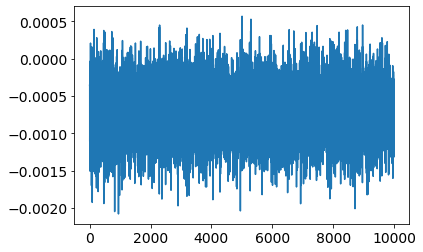

In [24]:
plt.plot(samples['alpha'])

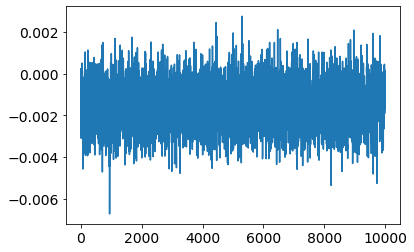

In [23]:
plt.plot(samples['alpha'])

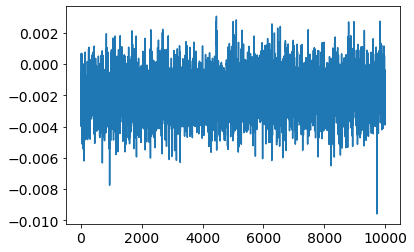

In [8]:
plt.plot(samples['alpha'])

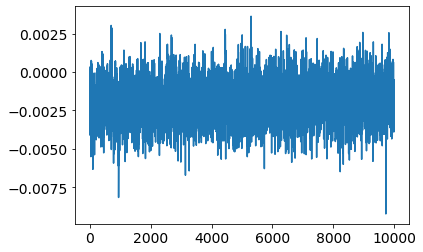

In [23]:
plt.plot(samples['alpha'])

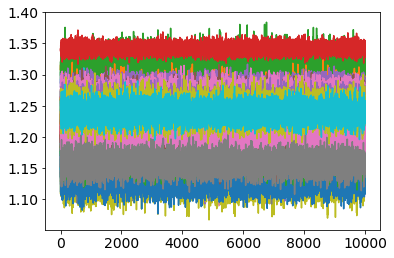

In [27]:
plt.plot(samples['GR_ind']);

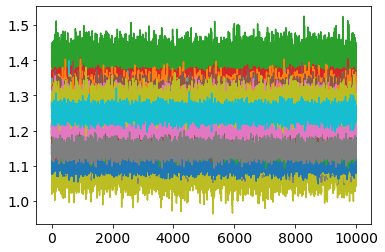

In [24]:
plt.plot(samples['GR_ind']);

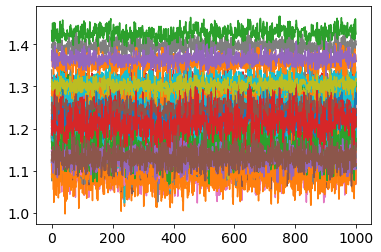

In [28]:
plt.plot(samples['GR_ind']);

In [29]:
len(t0)

78

In [30]:
2*(np.sum(t0.astype(np.int32))-(2*len(t0)+2+1))

DeviceArray(1828, dtype=int32)

# Parameter Marginals

Text(0.5, 0, 'Coefficient for Temperature [per C per day]')

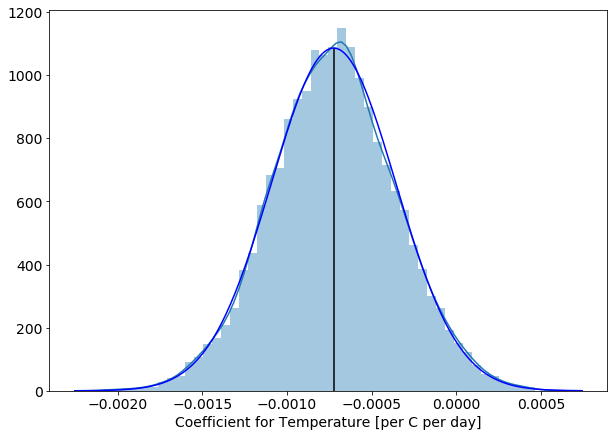

In [25]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
sns.distplot(samples['alpha'], bins=50, fit=norm, 
             fit_kws={'color':'blue'}, color='tab:blue', label=r'$alpha')
plt.vlines(np.mean(samples['alpha']), 0, norm.pdf(np.mean(samples['alpha']), *norm.fit(samples['alpha'])))
plt.xlabel('Coefficient for Temperature [per C per day]')

Text(0.5, 0, 'Coefficient for Temperature [per C per day]')

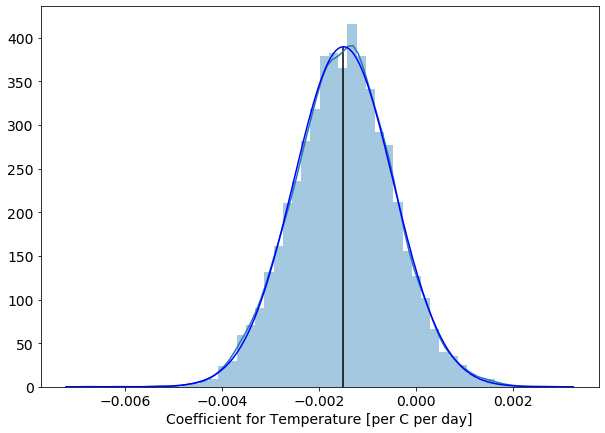

In [25]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
sns.distplot(samples['alpha'], bins=50, fit=norm, 
             fit_kws={'color':'blue'}, color='tab:blue', label=r'$alpha')
plt.vlines(np.mean(samples['alpha']), 0, norm.pdf(np.mean(samples['alpha']), *norm.fit(samples['alpha'])))
plt.xlabel('Coefficient for Temperature [per C per day]')

Text(0.5, 0, 'Coefficient for Temperature [per C per day]')

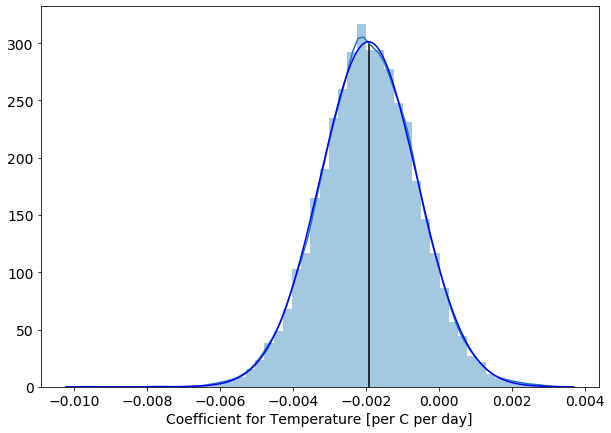

In [25]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
sns.distplot(samples['alpha'], bins=50, fit=norm, 
             fit_kws={'color':'blue'}, color='tab:blue', label=r'$alpha')
plt.vlines(np.mean(samples['alpha']), 0, norm.pdf(np.mean(samples['alpha']), *norm.fit(samples['alpha'])))
plt.xlabel('Coefficient for Temperature [per C per day]')

Text(0.5, 0, 'Coefficient for Temperature [per C per day]')

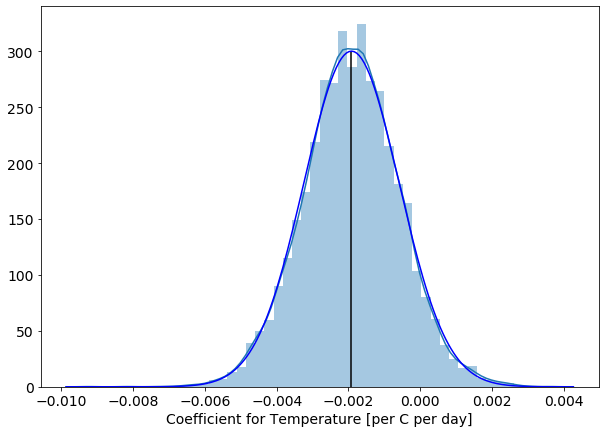

In [24]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
sns.distplot(samples['alpha'], bins=50, fit=norm, 
             fit_kws={'color':'blue'}, color='tab:blue', label=r'$alpha')
plt.vlines(np.mean(samples['alpha']), 0, norm.pdf(np.mean(samples['alpha']), *norm.fit(samples['alpha'])))
plt.xlabel('Coefficient for Temperature [per C per day]')

Text(0.5, 0, 'Coefficient for Temperature [per C per day]')

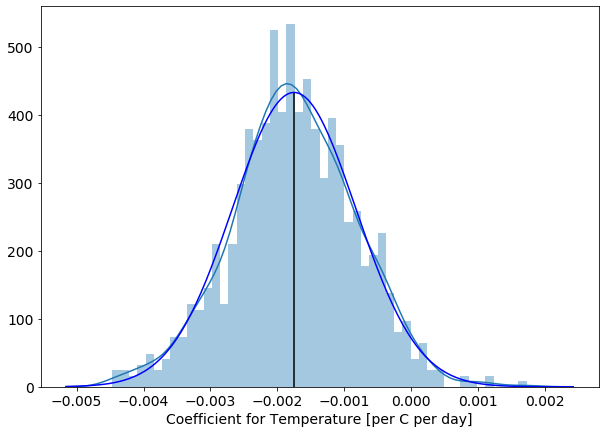

In [31]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
sns.distplot(samples['alpha'], bins=50, fit=norm, 
             fit_kws={'color':'blue'}, color='tab:blue', label=r'$alpha')
plt.vlines(np.mean(samples['alpha']), 0, norm.pdf(np.mean(samples['alpha']), *norm.fit(samples['alpha'])))
plt.xlabel('Coefficient for Temperature [per C per day]')

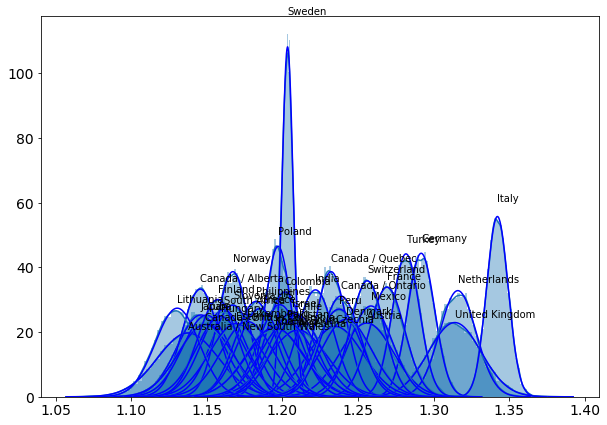

In [26]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
for i, c in enumerate(all_countries):
    mn = np.mean(samples['GR_ind'][:,i])
    std = np.std(samples['GR_ind'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10, verticalalignment='center')
    sns.distplot(samples['GR_ind'][:,i], bins=50, fit=norm, 
                 fit_kws={'color':'blue'}, color='tab:blue')

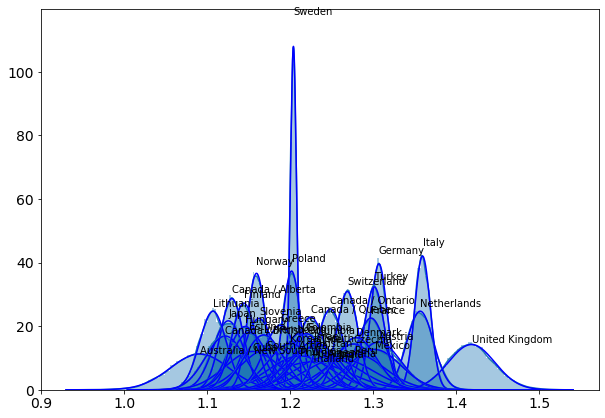

In [26]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
for i, c in enumerate(all_countries):
    mn = np.mean(samples['GR_ind'][:,i])
    std = np.std(samples['GR_ind'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10, verticalalignment='center')
    sns.distplot(samples['GR_ind'][:,i], bins=50, fit=norm, 
                 fit_kws={'color':'blue'}, color='tab:blue')

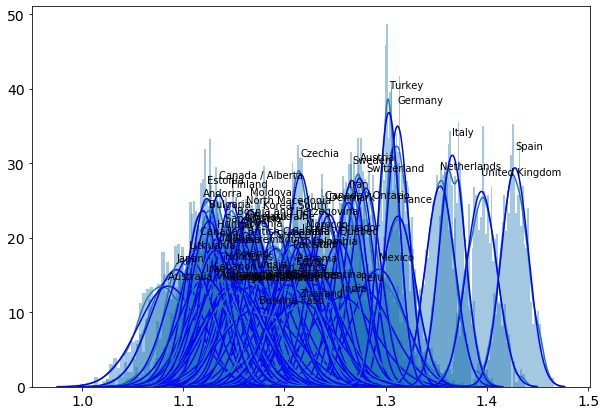

In [33]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
for i, c in enumerate(all_countries):
    mn = np.mean(samples['GR_ind'][:,i])
    std = np.std(samples['GR_ind'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10, verticalalignment='center')
    sns.distplot(samples['GR_ind'][:,i], bins=50, fit=norm, 
                 fit_kws={'color':'blue'}, color='tab:blue')

# Example Plots

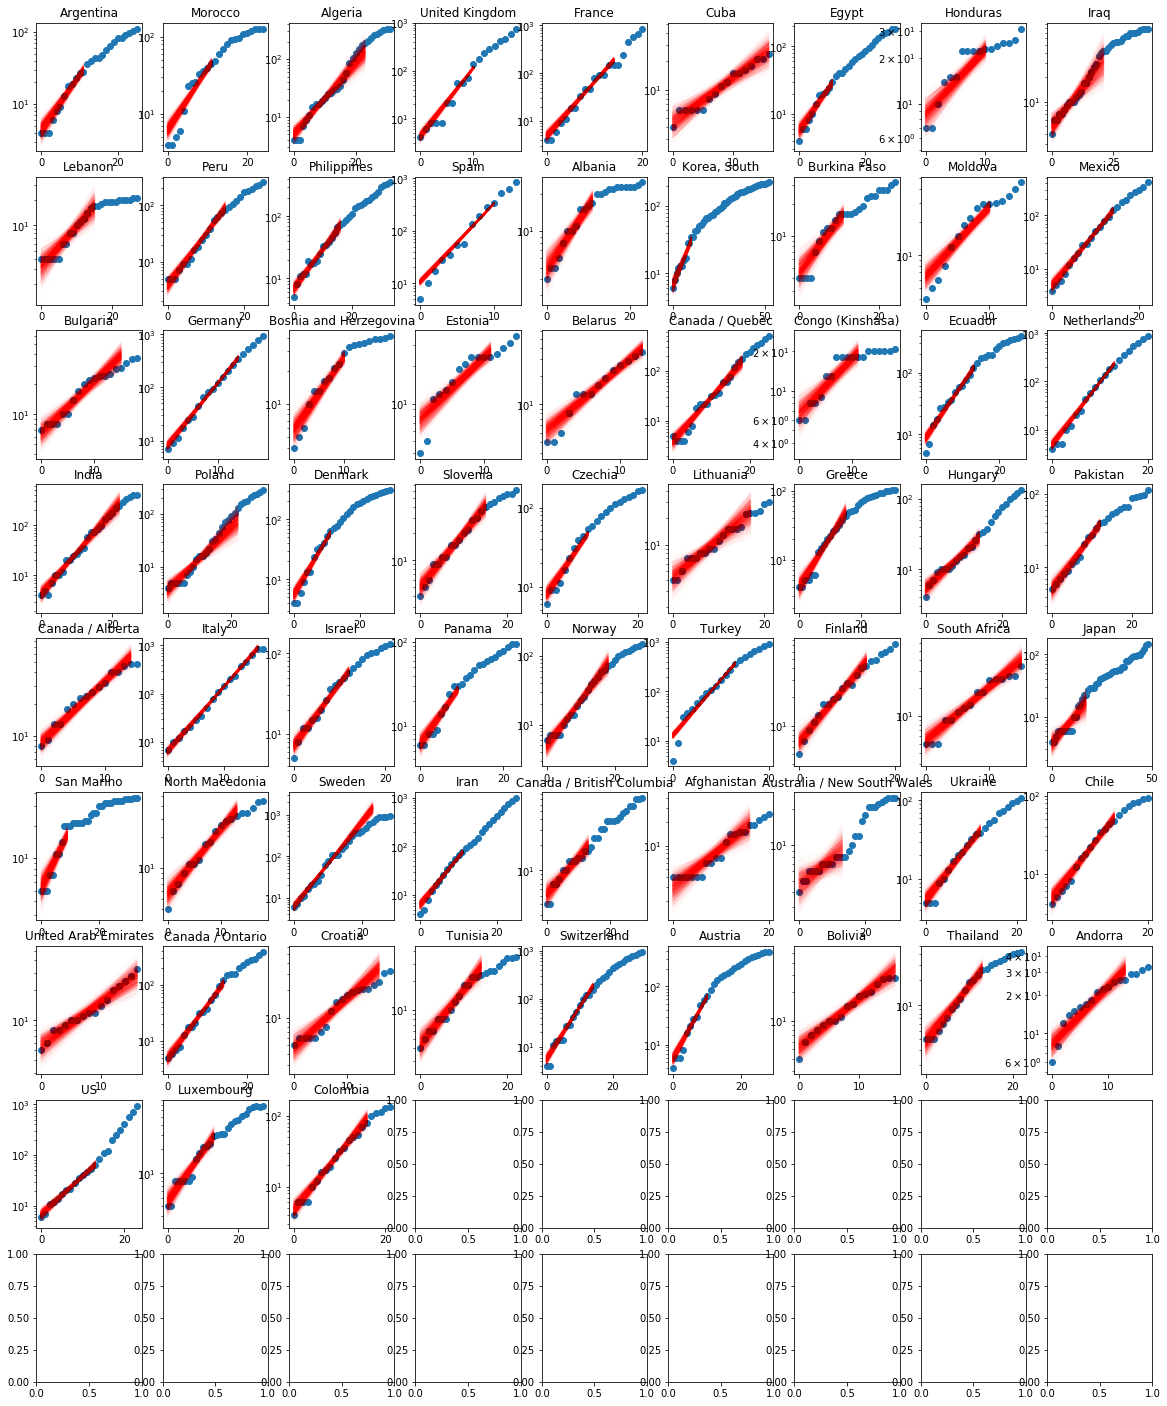

In [27]:
plt.rcParams['font.size'] = 10
fig,ax = plt.subplots(9, 9, figsize=(fig_scale*20,fig_scale*25))
a = ax.flatten()
for i, c in enumerate(all_countries):
    t = np.arange(len(deaths[c]))[:t0_dict[c]]
    a[i].set_title(c)
    a[i].semilogy(deaths[c], 'o')
    a[i].semilogy((samples['Di_ind'][::10,i:i+1]*(samples['GR_ind'][::10,i:i+1]+samples['alpha'][::10]*temps[c])**t[None,:]).T, 'r', alpha=0.01)
    
# plt.savefig('../plots/4.1_ExampleFits.png', dpi=200)     
plt.rcParams['font.size'] = 14

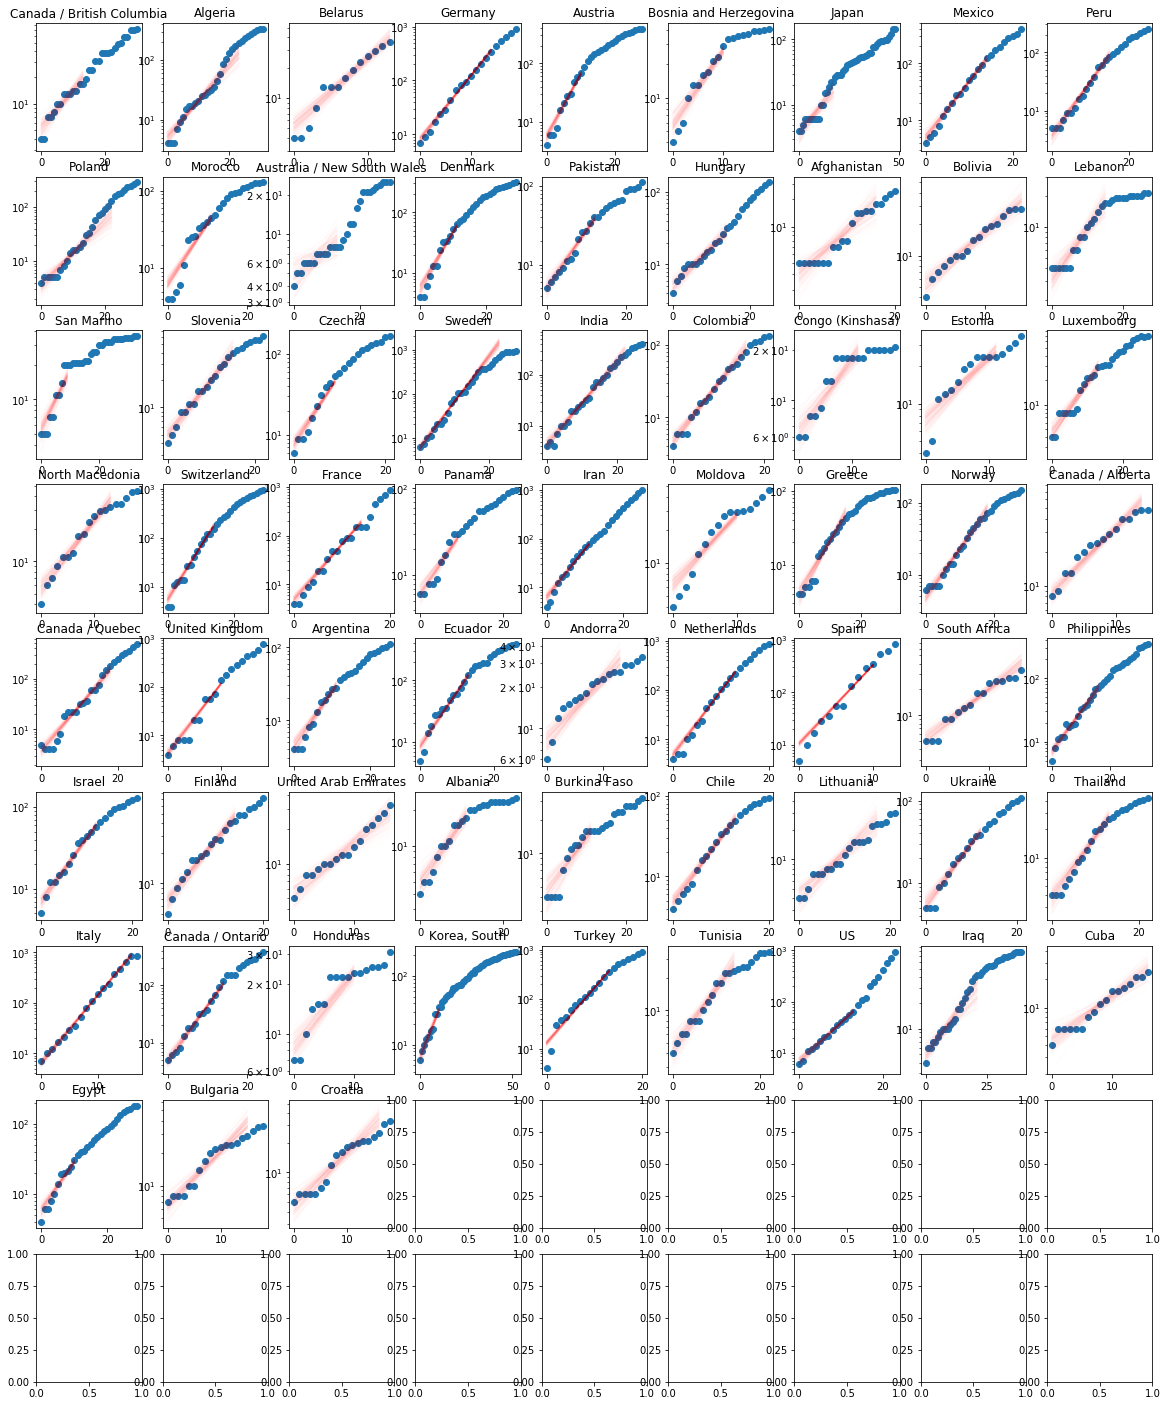

In [36]:
plt.rcParams['font.size'] = 10
fig,ax = plt.subplots(9, 9, figsize=(fig_scale*20,fig_scale*25))
a = ax.flatten()
for i, c in enumerate(all_countries):
    t = np.arange(len(deaths[c]))[:t0_dict[c]]
    a[i].set_title(c)
    a[i].semilogy(deaths[c], 'o')
    a[i].semilogy((samples['Di_ind'][::10,i:i+1]*(samples['GR_ind'][::10,i:i+1]+samples['alpha'][::10]*temps[c])**t[None,:]).T, 'r', alpha=0.01)
    
# plt.savefig('../plots/4.1_ExampleFits.png', dpi=200)     
plt.rcParams['font.size'] = 14